In [1]:
import matplotlib.pyplot as plt 
import time
import numpy as np
from tqdm import tqdm
import multipers as mp
import gudhi as gd
from gudhi.sklearn.cubical_persistence import CubicalPersistence
from sklearn.linear_model import LinearRegression


plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text in the plot
    "font.family": "serif",  # Often a good choice with LaTeX
    "font.serif": ["Computer Modern Roman"], # Or specify your preferred serif font
    # "font.sans-serif": ["Computer Modern Sans serif"], # If you use sans-serif
    # "font.monospace": ["Computer Modern Typewriter"] # If you use monospace
})

<frozen importlib._bootstrap>:488: UserWarning: 
            Found external software 2pac at /usr/bin/2pac
            but may not behave well.
            


In [2]:
def rademacher_brownian_motion(n, seed=None):
    """
    Generates a Brownian motion on [0, 1] with n regularly sampled points
    using a Rademacher random walk (steps are ±1 with equal probability),
    normalized for Brownian scaling.

    Args:
        n (int): Number of points (including start at 0).
        seed (int, optional): Random seed for reproducibility.

    Returns:
        np.ndarray: Array of Brownian motion values at n points in [0,1].
    """
    if seed is not None:
        np.random.seed(seed)
    dt = 1.0 / (n - 1)
    # Generate n-1 Rademacher random variables (+1 or -1)
    steps = np.random.choice([-1, 1], size=n-1)
    # Scale the steps for Brownian motion
    scaled_steps = steps * np.sqrt(dt)
    # Brownian path: start at 0, then cumulative sum
    bm = np.empty(n)
    bm[0] = 0.0
    bm[1:] = np.cumsum(scaled_steps)
    return bm

# Example usage:


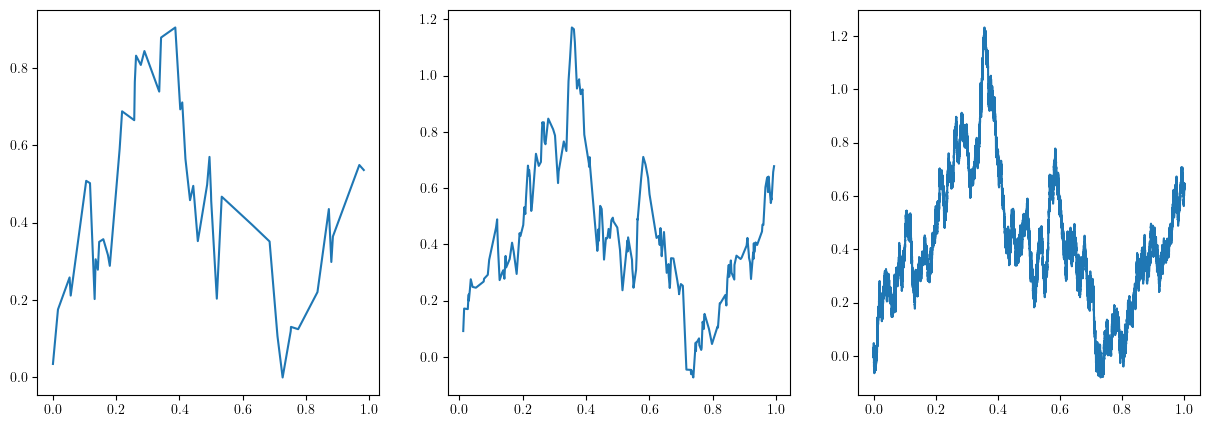

In [5]:
n = 1_000_000
for seed in [14]:
    bm_path = rademacher_brownian_motion(n, seed=seed)
    def sub_brownian(k: int):
        """
        Returns:
          t  : sorted uniform sample times in [0,1] (len k)
          y  : Brownian values at those times, using nearest-left indexing on a length-n discretization
          h  : sampling error = Hausdorff distance d_H({t_i}, [0,1])
              = max( t[0]-0, 1-t[-1], 0.5 * max_i (t[i+1]-t[i]) )

        Requires globals:
          - n: int, length of bm_path
          - bm_path: array of length n sampled at np.linspace(0,1,n)
        """
        if k <= 0:
            raise ValueError("k must be a positive integer")
        #print("sampling size: ",k)
        # uniformly sample and sort
        t = np.sort(np.random.uniform(0.0, 1.0, size=k))

        # map to discretized path (nearest-left index)
        idx = np.clip((t * (n - 1)).astype(int), 0, n - 1)
        y = bm_path[idx]

        # Hausdorff distance (fill distance) to [0,1]
        gaps = np.diff(np.concatenate(([0.0], t, [1.0])))
        internal_half = 0.5 * (gaps[1:-1].max() if gaps.size > 2 else 0.0)
        h = float(max(gaps[0], gaps[-1], internal_half))
        #print("The sampling error is ",h)
        return t, y, h


    fig, (a,b,c) = plt.subplots(ncols=3, figsize=(15,5))
    plt.sca(a)
    t, y, _ = sub_brownian(50)
    plt.plot(t, y)
    plt.sca(b)
    t, y, _ = sub_brownian(200)
    plt.plot(t, y)
    plt.sca(c)
    #plt.plot(*sub_brownian(1_000_000))
    t, y, _ = sub_brownian(1_000_000)
    plt.plot(t, y)
    plt.savefig(f"./output/brownian/brownian_motion_seed{seed}.pdf",  dpi=300, transparent = True, bbox_inches = 'tight')
    plt.show()

In [6]:
ground_truth = CubicalPersistence(homology_dimensions=[0], homology_coeff_field=2).fit_transform([sub_brownian(n)[1]])[0][0]

In [7]:
def get_bc_delaunay(k, degree=0):
    X,f,delta = sub_brownian(k)
    s = mp.filtrations.DelaunayLowerstar(X[:,None], f, reduce_degree=degree)
    #delta = 1/k
    bc= s.persistence_on_line(basepoint=[delta,0], direction=[0,1], full=False,)[degree]
    return bc[bc[:,0]!=bc[:,1]],delta
def get_bc_rips(k, degree=0):
    X,f,delta = sub_brownian(k)
    #delta = 1/k
    st = mp.filtrations.RipsLowerstar(X[:,None], f,threshold_radius=delta*(1.0001))
    st = st.project_on_line(basepoint=[delta,0], direction=[0,1])
    st.compute_persistence()
    bc= st.per
    return bc[bc[:,0]!=bc[:,1]]

In [8]:
N = 10_000
ks = np.logspace(1, np.log10(N),200, dtype=int)[:-1] # David's code

#N = 10000
#ks = np.linspace(10, N, 200, dtype=int)[:-1]
#ks = np.linspace(10, N, 100, dtype=int)[:-1]
#print("ks:",ks)
errors = []
deltas = []
for k in tqdm(ks):
    estimator, delta = get_bc_delaunay(k)
    btdist = gd.bottleneck_distance(ground_truth, estimator)
    errors.append(btdist)
    deltas.append(delta)
    
#errors = [gd.bottleneck_distance(ground_truth,get_bc_delaunay(k)) for k in tqdm(ks)]

100%|█████████████████████████████████████████| 199/199 [03:05<00:00,  1.07it/s]


In [9]:
#k=2000
#delta=1/k
#X,f = sub_brownian(k)
#st = mp.filtrations.RipsLowerstar(points=X[:,None], function=f, threshold_radius=1.01*k)
#mp.Slicer(st).persistence_on_line(basepoint=[delta,0], direction=[0,1])

In [10]:
#N = 100_000
#ks = np.logspace(1, np.log10(N),200, dtype=int)[:-1]
#bcN = get_bc_delaunay(N)
#errors = [gd.bottleneck_distance(bcN,get_bc_delaunay(k)) for k in tqdm(ks)]

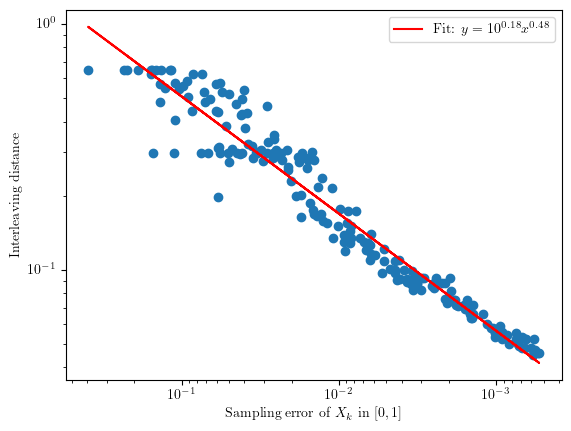

In [11]:

x = np.log10(deltas[:-1])
y = np.log10(errors[:-1])

lr = LinearRegression().fit(x[:, None], y)
a = lr.coef_[0]
b = lr.intercept_

fit_y = 10**(b + a * np.log10(deltas[:-1]))

#plt.plot(1/ks[:-1], errors[:-1])
#plt.plot(1/ks[:-1], fit_y, 'k--', label=f'Linear fit: log(y) = {a:.2g} log(x) + {b:.2g}')
plt.scatter(deltas[:-1], errors[:-1])
plt.plot(deltas[:-1],fit_y,color='red',label=fr'Fit: $y = 10^{{{b:.2f}}} x^{{{a:.2f}}}$')

plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel(fr"Sampling error of $X_k$ in $[0,1]$")
#plt.ylabel(r"$d_{\textnormal i}(\widehat{H_0(F)_k}, H_0(F))$")
plt.ylabel("Interleaving distance")
plt.legend()
plt.savefig(f"./output/brownian/cv_rate_brownian_seed{seed}_N{N}.pdf",  dpi=300, transparent = True, bbox_inches = 'tight')